<a href="https://colab.research.google.com/github/Thirukumaran02/AI-Powered-Customer-Journey-Sentiment-Analysis/blob/main/amazon_casestudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!file /content/data/train.xlsx

In [ ]:
# --------------------------
# Check / Upload Data
# --------------------------
import os, glob, zipfile
from google.colab import files

dataset_path = "/content/amazon/dataset/"

# Create folder if not exists
os.makedirs(dataset_path, exist_ok=True)

# Check for Excel files
excel_files = glob.glob(os.path.join(dataset_path, "*.xlsx"))

if not excel_files:  # If no Excel files, ask for upload
    print("No Excel files found in /content/amazon/dataset/")
    print("Please upload a ZIP file containing train.xlsx, validation.xlsx, and test.xlsx")

    uploaded = files.upload()
    for fn in uploaded.keys():
        if fn.endswith(".zip"):
            with zipfile.ZipFile(fn, 'r') as zip_ref:
                zip_ref.extractall(dataset_path)
            print(f"✅ Extracted {fn} into {dataset_path}")

# Re-check after upload
excel_files = glob.glob(os.path.join(dataset_path, "*.xlsx"))
print("Available Excel files:", excel_files)

Available Excel files: ['/content/amazon/dataset/validation.xlsx', '/content/amazon/dataset/train.xlsx', '/content/amazon/dataset/test.xlsx']


In [ ]:
# --------------------------
# Data Collection
# --------------------------
import pandas as pd

path_to_your_excel_files = "/content/amazon/dataset/"

# Load prepared splits
train_df = pd.read_excel(path_to_your_excel_files + "train.xlsx")
valid_df = pd.read_excel(path_to_your_excel_files + "validation.xlsx")
test_df  = pd.read_excel(path_to_your_excel_files + "test.xlsx")

print("Train:", train_df.shape,  "Validation:", valid_df.shape, "Test:", test_df.shape)

display(train_df.head(3))

Train: (1048575, 9) Validation: (30000, 9) Test: (30000, 9)


,Unnamed: 0,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,0,de_0203609,product_de_0865382,reviewer_de_0267719,1,Armband ist leider nach 1 Jahr kaputt gegangen,Leider nach 1 Jahr kaputt,de,sports
1,1,de_0559494,product_de_0678997,reviewer_de_0783625,1,In der Lieferung war nur Ein Akku!,EINS statt ZWEI Akkus!!!,de,home_improvement
2,2,de_0238777,product_de_0372235,reviewer_de_0911426,1,"Ein Stern, weil gar keine geht nicht. Es hande...",Achtung Abzocke,de,drugstore


In [ ]:
# --------------------------
# Dataset-Level Cleaning
# --------------------------
import re
import pandas as pd

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_and_report(df, name):
    original_rows = df.shape[0]

    # Drop nulls
    df.dropna(subset=["review_body", "stars"], inplace=True)

    # Convert stars
    df["stars"] = pd.to_numeric(df["stars"], errors="coerce").astype("Int64")

    # Remove duplicates
    before_dupes = df.shape[0]
    df.drop_duplicates(subset=["review_body"], inplace=True)
    dupes_removed = before_dupes - df.shape[0]

    # Clean text
    df["review_body"] = df["review_body"].apply(clean_text)

    # Filter very short reviews (<3 words)
    before_short = df.shape[0]
    df = df[df["review_body"].str.split().str.len() >= 3]
    short_removed = before_short - df.shape[0]

    # Report
    print(f"\n Report for {name} set")
    print("-" * 40)
    print(f"Original rows         : {original_rows:,}")
    print(f"After cleaning        : {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Nulls removed         : {original_rows - before_dupes:,}")
    print(f"Duplicates removed    : {dupes_removed:,}")
    print(f"Too-short removed     : {short_removed:,}")

    # Avg review length
    avg_len = df["review_body"].str.split().str.len().mean()
    print(f"Avg review length     : {avg_len:.2f} words")

    return df

# Apply to all splits
train_df = preprocess_and_report(train_df, "Train")
valid_df = preprocess_and_report(valid_df, "Validation")
test_df  = preprocess_and_report(test_df, "Test")

# --------------------------
# Class Distribution in Train
# --------------------------
print("\n Class Distribution (Stars in Train set)")
print("-" * 40)
class_dist = (
    train_df["stars"]
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(2)
)

for stars, perc in class_dist.items():
    count = train_df["stars"].value_counts().sort_index()[stars]
    print(f" {stars}: {count:,} reviews ({perc:.2f}%)")



 Report for Train set
----------------------------------------
Original rows         : 819,437
After cleaning        : 813,982 rows × 9 columns
Nulls removed         : 0
Duplicates removed    : 5,455
Too-short removed     : 0
Avg review length     : 32.24 words

 Report for Validation set
----------------------------------------
Original rows         : 20,798
After cleaning        : 20,752 rows × 9 columns
Nulls removed         : 0
Duplicates removed    : 46
Too-short removed     : 0
Avg review length     : 31.50 words

 Report for Test set
----------------------------------------
Original rows         : 20,833
After cleaning        : 20,794 rows × 9 columns
Nulls removed         : 0
Duplicates removed    : 39
Too-short removed     : 0
Avg review length     : 31.59 words

 Class Distribution (Stars in Train set)
----------------------------------------
 1: 166,205 reviews (20.42%)
 2: 164,090 reviews (20.16%)
 3: 162,740 reviews (19.99%)
 4: 161,500 reviews (19.84%)
 5: 159,447 review

In [ ]:
# --------------------------
# NLP Cleaning
# --------------------------
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources (only once)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("punkt_tab") # Download the missing resource

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text_for_ml(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)              # keep only letters
    tokens = nltk.word_tokenize(text)                    # better tokenization
    tokens = [lemmatizer.lemmatize(w)
              for w in tokens if w not in stop_words]    # stopword removal + lemmatization
    return " ".join(tokens)

# Apply
for name, df in {"Train": train_df, "Validation": valid_df, "Test": test_df}.items():
    df["clean_review"] = df["review_body"].apply(clean_text_for_ml)
    empty_removed = (df["clean_review"] == "").sum()
    # df = df[df["clean_review"] != ""]  # drop empty reviews - Note: This line was commented out as it modifies the loop variable directly and won't persist changes outside the loop.
    print(f"{name}: added 'clean_review' column (removed {empty_removed} empty rows)")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Train: added 'clean_review' column (removed 6886 empty rows)
✅ Validation: added 'clean_review' column (removed 306 empty rows)
✅ Test: added 'clean_review' column (removed 321 empty rows)


In [68]:
%pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=d8f16996c6784dc622a563bf1ae081cf80b3fd43b304beb7af9365bee5504f81
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


/tmp/ipython-input-2914489015.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="stars", data=train_df, palette="Set2")


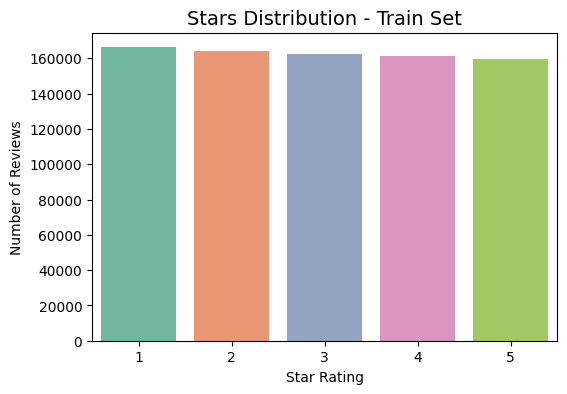

In [69]:
# ======================================
# Part 3: Exploratory Data Analysis (EDA)
# ======================================
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from langdetect import detect
import langcodes

# Stars Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="stars", data=train_df, palette="Set2")
plt.title("Stars Distribution - Train Set", fontsize=14)
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

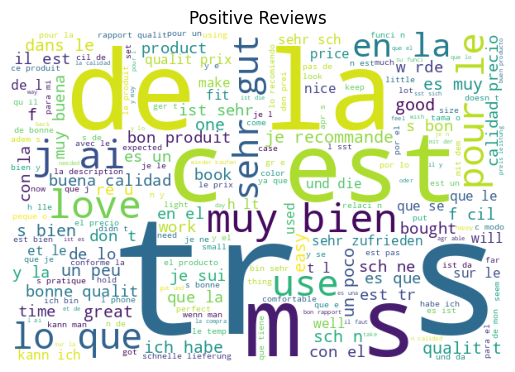

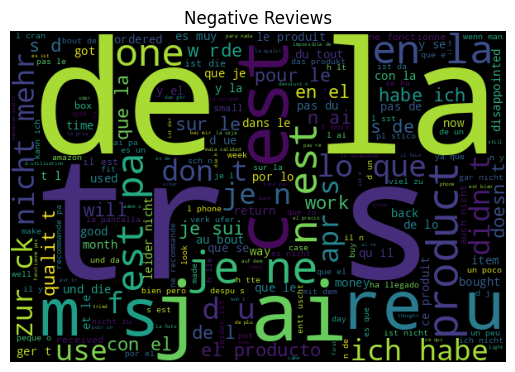

In [71]:
# WordCloud for positive & negative reviews
positive_text = " ".join(train_df[train_df["stars"]>=4]["review_body"].astype(str))
negative_text = " ".join(train_df[train_df["stars"]<=2]["review_body"].astype(str))

wc_pos = WordCloud(width=600, height=400, background_color="white").generate(positive_text)
wc_neg = WordCloud(width=600, height=400, background_color="black").generate(negative_text)

plt.imshow(wc_pos); plt.axis("off"); plt.title("Positive Reviews"); plt.show()
plt.imshow(wc_neg); plt.axis("off"); plt.title("Negative Reviews"); plt.show()

/tmp/ipython-input-1743761426.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lang_counts.values, y=lang_counts.index, palette="viridis")


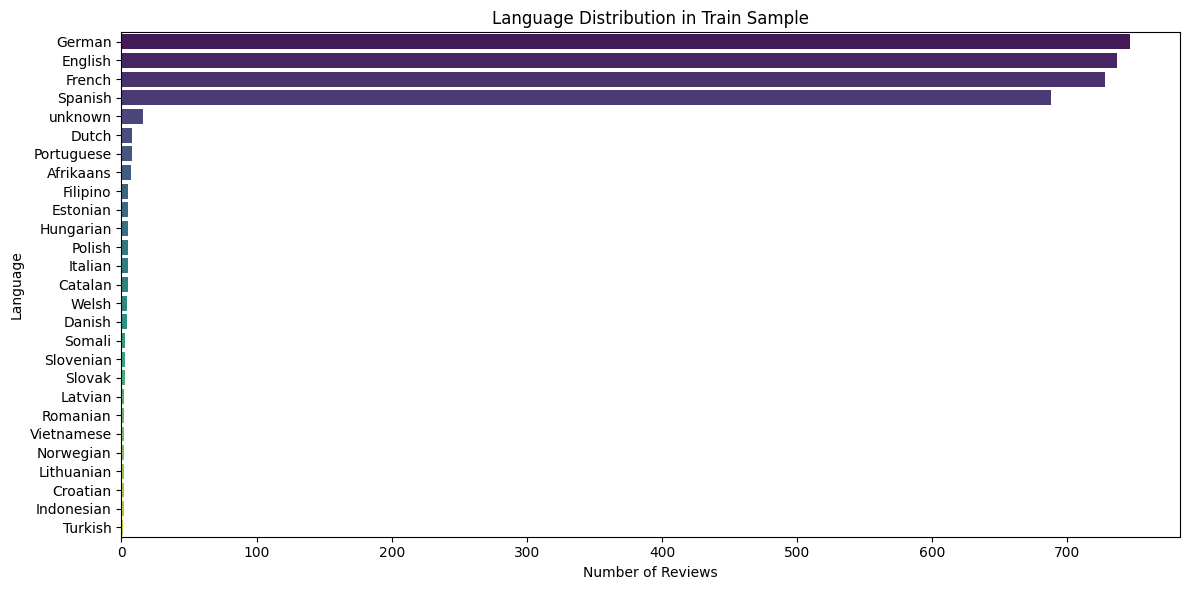

In [89]:
#language distribution

from langdetect import detect
import langcodes
import seaborn as sns
import matplotlib.pyplot as plt

def detect_lang_safe(text):
    try:
        code = detect(str(text))
        return langcodes.Language.get(code).display_name()
    except:
        return "unknown"

# Sample 3000 rows for speed and add language column
sampled_df = train_df["review_body"].sample(3000).apply(detect_lang_safe)
lang_counts = sampled_df.value_counts()

# Plotting as a horizontal bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=lang_counts.values, y=lang_counts.index, palette="viridis")
plt.title("Language Distribution in Train Sample")
plt.xlabel("Number of Reviews")
plt.ylabel("Language")
plt.tight_layout()
plt.show()

In [80]:
# Baseline Model (TF-IDF + Logistic Regression)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

# Prepare text & labels
X_train, y_train = train_df["review_body"], train_df["stars"]
X_valid, y_valid = valid_df["review_body"], valid_df["stars"]

# Handle missing text
X_train = X_train.replace(np.nan, '', regex=True)
X_valid = X_valid.replace(np.nan, '', regex=True)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = lr.predict(X_valid_tfidf)
print(classification_report(y_valid, y_pred))


              precision    recall  f1-score   support

         1.0       0.59      0.67      0.63      4205
         2.0       0.43      0.39      0.41      4164
         3.0       0.39      0.38      0.39      4151
         4.0       0.46      0.38      0.42      4149
         5.0       0.62      0.70      0.66      4083

    accuracy                           0.51     20752
   macro avg       0.50      0.51      0.50     20752
weighted avg       0.50      0.51      0.50     20752



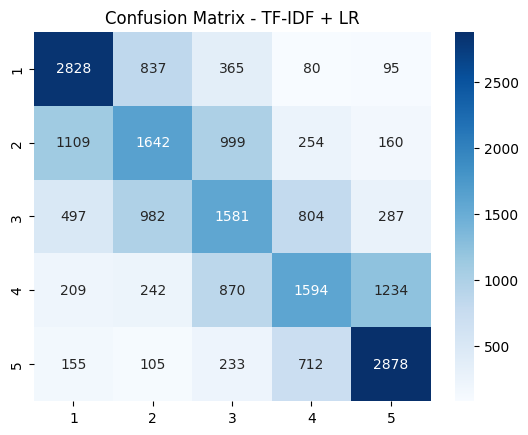

In [81]:
# Model Evaluation

from sklearn.metrics import confusion_matrix, accuracy_score

# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y_train.unique()),
            yticklabels=sorted(y_train.unique()))
plt.title("Confusion Matrix - TF-IDF + LR")
plt.show()


/tmp/ipython-input-1265853462.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="lang", y="accuracy", data=lang_report, palette="viridis")


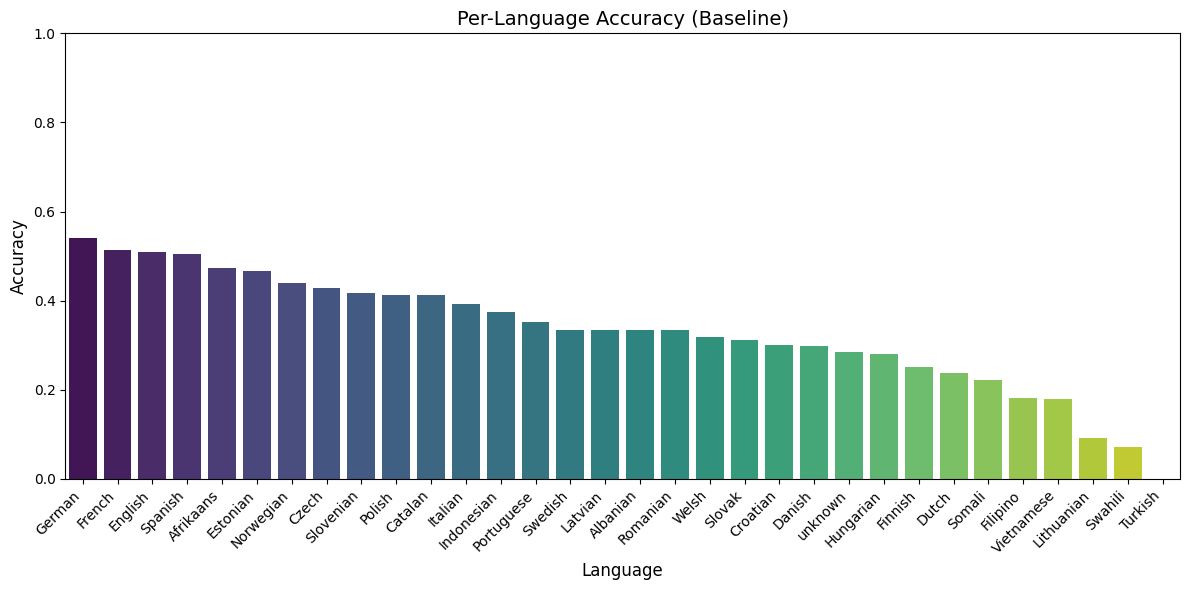

In [84]:
# Per-language accuracy on validation
# Sort by accuracy for cleaner visualization
lang_report = lang_report.sort_values("accuracy", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x="lang", y="accuracy", data=lang_report, palette="viridis")

plt.title("Per-Language Accuracy (Baseline)", fontsize=14)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=45, ha="right")  # rotate for readability
plt.ylim(0,1)  # accuracy between 0 and 1
plt.tight_layout()
plt.show()


In [92]:
%pip install evaluate transformers datasets accelerate

In [ ]:
# ======================================
# Optional: Improved TF-IDF + Logistic Regression
# ======================================
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Prepare text & labels for test set
X_test, y_test = test_df["review_body"], test_df["stars"]

# Handle missing text in test set
X_test = X_test.replace(np.nan, '', regex=True)

# Build pipeline with bigger TF-IDF features + bigrams
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('lr', LogisticRegression(max_iter=1500))
])

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_pred_valid = pipeline.predict(X_valid)
y_pred_test  = pipeline.predict(X_test)

# Validation performance
acc_valid = accuracy_score(y_valid, y_pred_valid)
print(f"Validation Accuracy: {acc_valid:.4f}")
print("Validation Classification Report:")
print(classification_report(y_valid, y_pred_valid))

# Test performance
acc_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {acc_test:.4f}")
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix on Test set
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y_train.unique()),
            yticklabels=sorted(y_train.unique()))
plt.title("Confusion Matrix - TF-IDF + LR (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:

# Predict on test set
test_hf = Dataset.from_pandas(test_df[["review_body", "stars"]])
test_hf = test_hf.map(tokenize, batched=True)

preds = trainer.predict(test_hf)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred))


In [91]:
# Model Explainability (Interpretability)

import shap

# Use LinearExplainer for logistic regression and TF-IDF features
explainer = shap.LinearExplainer(lr, X_valid_tfidf, feature_names=tfidf.get_feature_names_out())

# Select a few samples for explanation
shap_values = explainer(X_valid_tfidf[:5])

# Plot the explanation
shap.plots.text(shap_values)

AttributeError: 'numpy.float64' object has no attribute 'replace'

In [ ]:
# Final Test Set Evaluation
test_hf = Dataset.from_pandas(test_df[["review_body", "stars"]])
test_hf = test_hf.map(tokenize, batched=True)

preds = trainer.predict(test_hf)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


In [ ]:
# Deployment (Streamlit App)
import streamlit as st

st.title("🌍 Multilingual Sentiment Analyzer")

uploaded = st.file_uploader("Upload an Excel file", type=["xlsx"])
if uploaded:
    df = pd.read_excel(uploaded)
    st.write("Preview:", df.head())

    # Baseline model prediction
    X = tfidf.transform(df["review_body"].fillna(''))
    preds = lr.predict(X)
    df["predicted_sentiment"] = preds

    st.write(df.head())
    st.download_button("Download Results", df.to_csv(index=False), "results.csv")
